# EDA
Relatively quick check to see which features to drop/preprocess to get things going.

I. Inspect raw featurs and preprocess them to a numeric format.  
II. Analyse processed features + additional feature engineering.

In [23]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

% matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 5)

### Helper Functions

In [24]:
def plot_hist(df: pd.DataFrame, col: str):
    """Plot histogram of column and conditional distribution of survival rate wrt to colum."""
    df.groupby(col)["survived"].describe()[["count", "mean"]].rename(columns={"mean": "survival"}) \
        .plot(kind="bar", secondary_y="survival", title="Histogram and survival rate of {}".format(col))
    plt.show()

In [25]:
raw = pd.read_csv("../data/titanic.csv")

raw.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
# missing values
raw.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

## I. Raw Feature Inspection/Processing

Go through each feature and add/drop/process it accordingly

In [27]:
df = pd.DataFrame()

### 0. survived
The endogenous variable, not much to do here

In [28]:
# see class imbalance
print("class ratio: {:.2%}".format(raw["survived"].mean()))

# add to final df
df["survived"] = raw["survived"]

class ratio: 38.38%


### 1. ticket 
Drop to save time

In [29]:
raw = raw.drop(["ticket"], axis=1)

### 2. cabin
Use Cabin first letter (floor?) as a feature.  
We ca see from the survival rate per floor that it does have discrimintatory power.  

Missing values in ´cabin´: 687


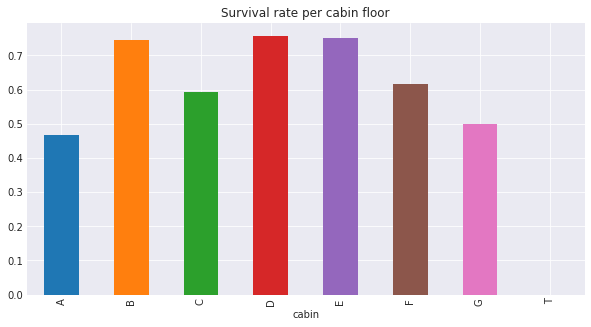

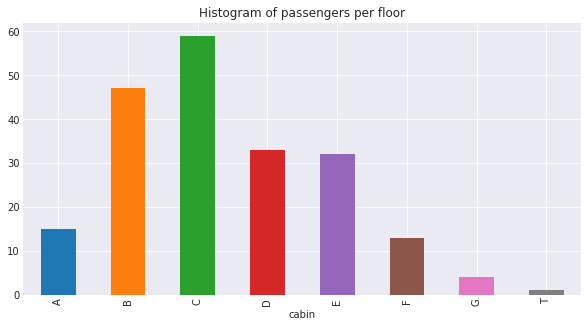

In [30]:
n_cabin_nans = raw["cabin"].isnull().sum()
print("Missing values in ´cabin´: {}".format(n_cabin_nans))

# survival rate per cabin floor
raw.groupby(raw["cabin"].str[0])["survived"].mean() \
    .plot(kind="bar", title="Survival rate per cabin floor")
plt.show()

# distribution of cabins
raw.groupby(raw["cabin"].str[0])["survived"].count()\
    .plot(kind="bar", title="Histogram of passengers per floor")
plt.show()

# add to final df
df["cabin_floor"] = np.log(LabelEncoder().fit_transform(raw["cabin"].str[0].fillna("")) + 1)

### 3. pclass
Keep pclass as is - it is definiely important.  
We can see this from the distribution of passengers over the class and the conditional probability on survival rate.  

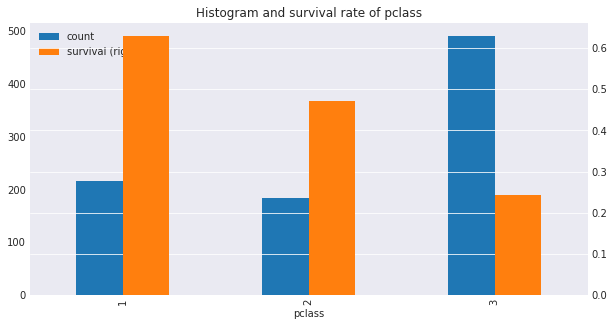

In [31]:
# distribution and survial rate based on pclass
plot_hist(raw, "pclass")

# add to final df
df["pclass"] = raw["pclass"]

### 4. sex
Use binary encoding.
Sex is a pretty good indicator given the survival rate.   
Can expect the minimum classifier accuracy to be 74%.  

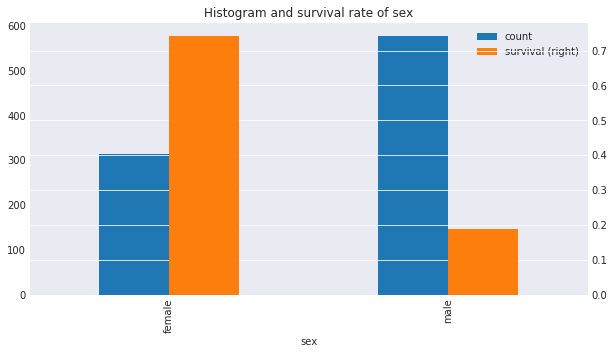

In [32]:
plot_hist(raw, "sex")

# add to final df
df["sex"] = LabelEncoder().fit_transform(raw["sex"])

### 5. Age
Keep as is, attention not to impute with 0 as it would mess up prediciton.
From the surival rate per age we can see that extremes have better odds - Expect to see a low linear correlation, parabolic corr would be a better indicator.  
Dropping the feature based on pearson corr would be a mistake. Further proof that filter feature selection is bogus.   

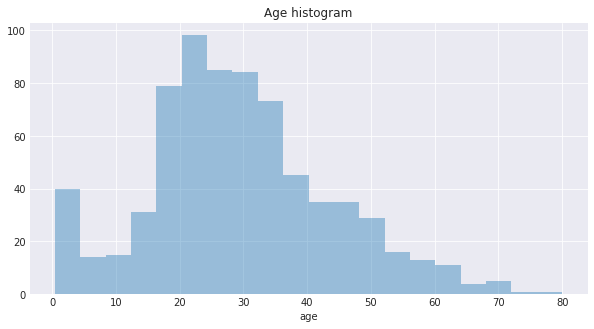

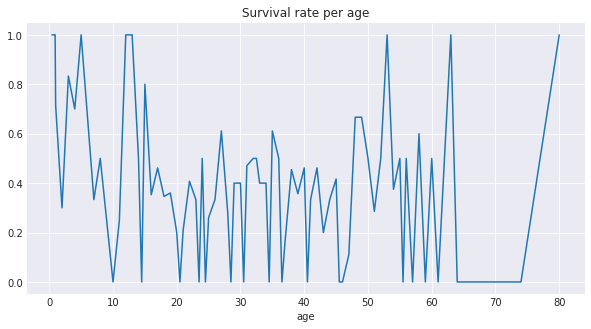

Pearson Corr: -0.0772


In [33]:
# Age histogram
plt.title("Age histogram")
sns.distplot(raw["age"].dropna(), kde=False)
plt.show()

# conditional
raw.groupby("age")["survived"].mean().plot(kind="line", title="Survival rate per age")
plt.show()

# pearson corr
print("Pearson Corr: {:.4f}".format(raw["age"].corr(raw["survived"])))

# add to final df
df["age"] = raw["age"]

### 6. fare
Has some extreme values, we should log it in the engineering part.

corr raw: 0.257306522385


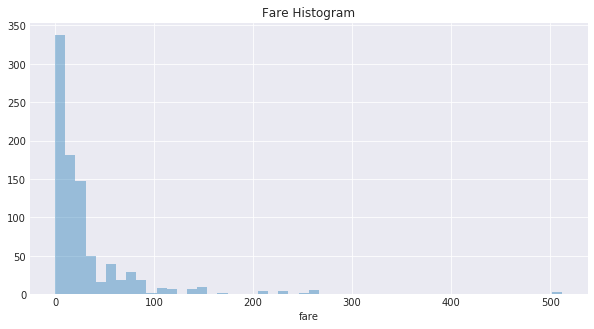

In [34]:
print("corr raw:", raw["fare"].corr(raw["survived"]))
plt.title("Fare Histogram")
sns.distplot(raw["fare"], kde=False)
plt.show()

# add to final df
df["fare"] = raw["fare"]

### 7. name
Create features based on last name. The idea is that one might be able to deduce the survival rate of a person based on the relatives.  
Features: name_mean_fare, name_count    
Attention to train test split to avoid information leak between train and test split - super important and a lot of ppl mess this up.  

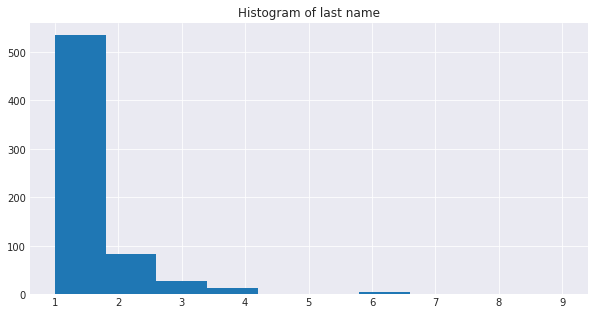

Sample features


,name,fare,count
0,Abbing,7.55,0.000000
1,Abbott,20.25,0.693147
2,Abelson,24.00,0.693147
3,Adahl,7.25,0.000000
4,Adams,8.05,0.000000


In [35]:
names = raw["name"].str.split(",").apply(lambda x: x[0])
plt.title("Histogram of last name")
names.value_counts().hist()
plt.show()

# Create Features
name_feats = df.groupby(names)[["fare"]].mean()
name_feats["count"] = np.log(df.groupby(names)["survived"].count())
name_feats = name_feats.reset_index()
print("Sample features")
display(name_feats.head())

# add to final df
name_feats = pd.merge(names.to_frame(), name_feats, left_on="name", right_on="name")
df["name_mean_fare"] = name_feats["fare"]
df["name_count"] = name_feats["count"]

### 8 - 9. sibsp and parch
Number of Sibling and Spouses (SibSp) and number of Parents and Children (ParCh).  
Might want to log a bit as well in the enginnering part. 

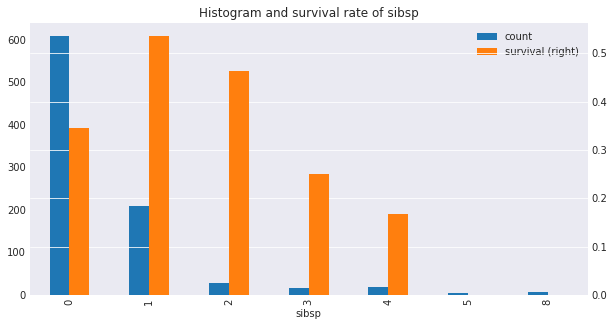

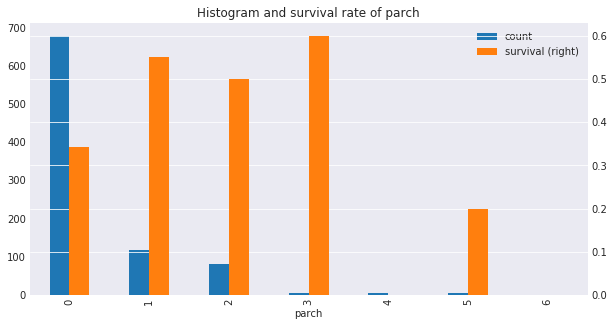

In [36]:
plot_hist(raw, "sibsp")
plot_hist(raw, "parch")

# add to final df
df[["sibsp", "parch"]] = raw[["sibsp", "parch"]]

### 10. Embarked
One hot encoding of ports as there are not ordinal values.  

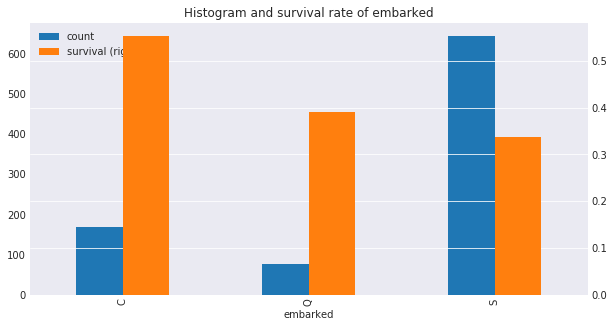

In [37]:
plot_hist(raw, "embarked")

# add to final df
cols = ["embarked_" + str(i) for i in range(4)]
df = pd.concat([df, pd.DataFrame(LabelBinarizer().fit_transform(raw["embarked"].fillna("X")), columns=cols)], axis=1)

## II. Feature Analysis
Analysing the features produces in step I.  
Feature selection, decorrelation, outlier detection etc comes here  

In [38]:
df.describe()

,survived,cabin_floor,pclass,sex,age,fare,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.325570,2.308642,0.647587,29.699118,32.204208,32.204208,0.426683,0.523008,0.381594,0.188552,0.086420,0.722783,0.002245
std,0.486592,0.620293,0.836071,0.477990,14.526497,49.693429,48.951667,0.586137,1.102743,0.806057,0.391372,0.281141,0.447876,0.047351
min,0.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,20.125000,7.910400,8.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,3.000000,1.000000,28.000000,14.454200,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,3.000000,1.000000,38.000000,31.000000,31.000000,0.693147,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,2.197225,3.000000,1.000000,80.000000,512.329200,512.329200,2.197225,8.000000,6.000000,1.000000,1.000000,1.000000,1.000000


### 1. Missing Values
Only age has to be imputed, creating separate feature with missing_age.

In [39]:
df["missing_age"] = df["age"].isnull().astype(int)
df["age"] = df["age"].fillna(0)

### 2. Correlation
Some high correlations, but nothing being extreme so leave it as is.

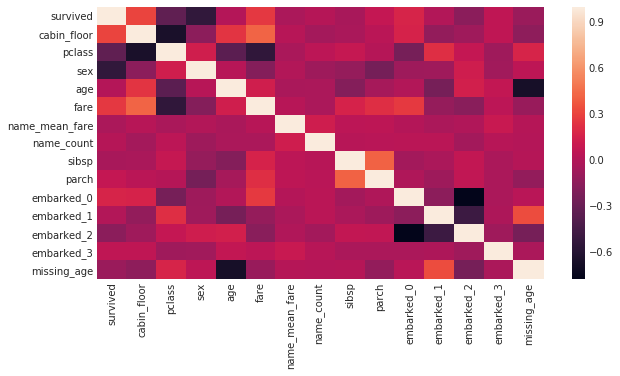

In [40]:
sns.heatmap(df.corr())
plt.show()

##### PCA to decorrelate, one dimension pops up but not that much. Could add it as an extra feature.

In [41]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pca = PCA().fit(RobustScaler().fit_transform(df))
pca.explained_variance_ratio_

array([  3.58027667e-01,   3.17888099e-01,   1.00279391e-01,
         4.96995414e-02,   4.45808081e-02,   3.39565461e-02,
         2.99645049e-02,   1.85620130e-02,   1.78661277e-02,
         1.13620681e-02,   7.55552040e-03,   6.32049700e-03,
         3.73352528e-03,   2.03690574e-04,   1.39808262e-33])

### 3. Distributions/Outliers
All are more or less well behaved, we can log a bunch of geom distributed feats to normalize more or less

survived


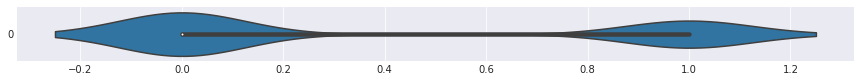

cabin_floor


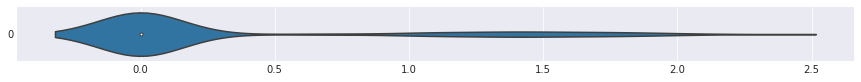

pclass


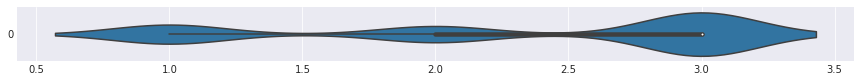

sex


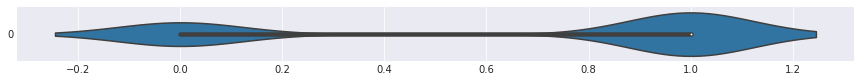

age


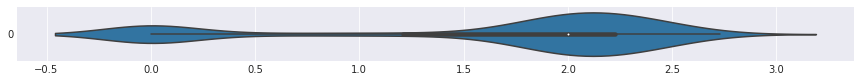

fare


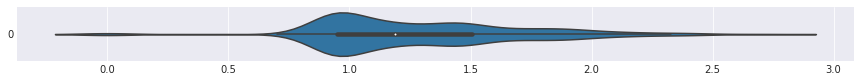

name_mean_fare


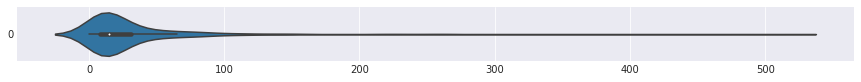

name_count


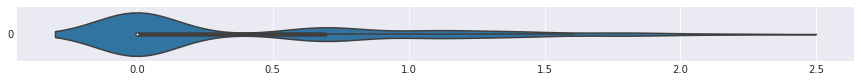

sibsp


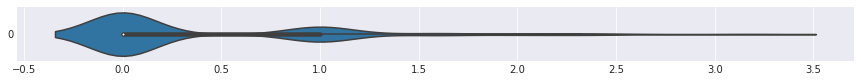

parch


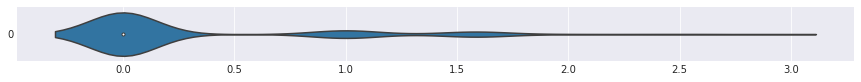

embarked_0


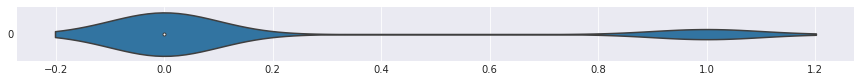

embarked_1


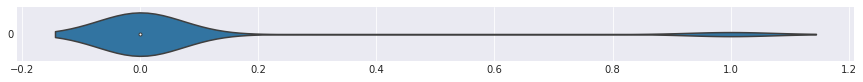

embarked_2


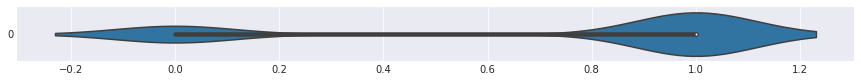

embarked_3


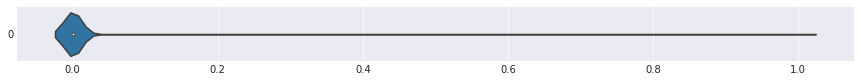

missing_age


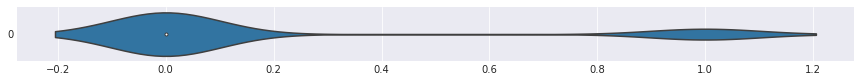

In [42]:
# gracefully log each accordinly
df["fare"] = np.log10(df["fare"] + 1)
df["age"] = np.log(df["age"] + 1) / np.log(5)  # base 5
df["sibsp"] = np.log2(df["sibsp"] + 1)
df["parch"] = np.log2(df["parch"] + 1)

for col in df.columns:
    print(col)
    plt.figure(figsize=(15,1))
    sns.violinplot(data=df[col], orient="h")
    plt.show()

### 4. Final DF
Df will have to recomputed before modelling, just on the train split

In [43]:
df = pd.DataFrame(RobustScaler().fit_transform(df), columns=df.columns)
df.describe()

,survived,cabin_floor,pclass,sex,age,fare,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3,missing_age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.325570,-0.691358,-0.352413,-0.370899,0.175488,0.771425,0.615574,0.406608,0.314048,0.188552,0.086420,-0.277217,0.002245,0.198653
std,0.486592,0.620293,0.836071,0.477990,0.878015,0.757946,2.132970,0.845618,0.667734,0.593929,0.391372,0.281141,0.447876,0.047351,0.399210
min,0.000000,0.000000,-2.000000,-1.000000,-1.965595,-2.141449,-0.631808,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,-1.000000,-1.000000,-0.777332,-0.430704,-0.281046,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.222668,0.569296,0.718954,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.197225,0.000000,0.000000,0.717860,2.739919,21.691904,3.169925,3.169925,2.807355,1.000000,1.000000,0.000000,1.000000,1.000000


### 5. Embedded vis
Getting a nice separation already. Shouldn't be overly interpreted though.

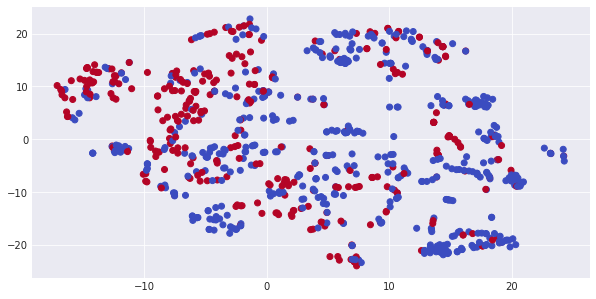

In [44]:
from sklearn.manifold import TSNE

embd = TSNE().fit_transform(df.drop("survived", axis=1))
plt.scatter(embd[:, 0], embd[:, 1], cmap="coolwarm", c=df["survived"])
plt.show()